# Plot lapse rate CFAD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import cmocean
import xarray as xr
import pandas as pd
import seaborn as sns
from orcestra_read_data import *
from thermo_functions import *

In [2]:
# def compute_cfad(invar, bins):
#     nz = invar.shape[1]
#     nbin = len(bins)
#     var_freq=np.zeros((nbin-1,nz))
#     for iz in range(nz):
#         count, placeholder = np.histogram(invar[:,iz], bins=bins)
#         # var_freq[:,iz] = 100 * count / np.sum(count)
#         var_freq[:,iz] = count
#     return var_freq
def compute_cfad(invar, bins):
    nz = invar.shape[1]
    nbin = len(bins)
    hist_density=np.zeros((nbin-1,nz))
    for iz in range(nz):
        count, bin_edges = np.histogram(invar[:,iz], bins=bins, density=True)
        hist_density[:,iz] = count
    return hist_density, bin_edges

In [3]:
# Vertical smoothing function
def vert_smooth(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    invar_pd = (invar_pd.transpose()).rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(invar_pd).transpose())

Read in data

In [4]:
#root_radio = 'https://ipfs.io/ipfs/QmSUUUPcGcpwdJJCVDGPGYksLsqkWbfh6d6xFcTk2Qu7Zf'
#CID: QmbZQh6TcKVaWLj2x5UxqJ2nWcY3He1qwpsVQjCcUip7wq
root_radio = 'ipns://latest.orcestra-campaign.org/products/Radiosondes'
dset_radio = xr.open_dataset(f"{root_radio}/RAPSODI_RS_ORCESTRA_level2.zarr",engine="zarr")
#dset_radio = xr.open_dataset(f"https://ipfs.io/ipfs/QmbZQh6TcKVaWLj2x5UxqJ2nWcY3He1qwpsVQjCcUip7wq", engine="zarr")
snd_asc = read_soundings(platform='RV_Meteor', ascent=0) #Read ascending soundings

# Mask soundings that don't reach 100 hPa
snd_asc, min_pres = mask_soundings(snd_asc, p_threshold=100)

times_asc = snd_asc['times']
hght = snd_asc['hght']

Calculate

In [5]:
# Static stability
theta = theta_dry(snd_asc['tmpk'], snd_asc['p'])
theta = vert_smooth(theta, nz_smooth=10)
dthdz = np.gradient(theta, hght, axis=1) # K/m
dthdz = vert_smooth(dthdz, nz_smooth=10)

# plot lapse rate CFAD

/opt/anaconda3/envs/awing/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_31027/1172226875.py:17: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar, axis=0)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_31027/1172226875.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_31027/1172226875.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_31027/1172226875.py:50: UserWarning: set_ticklabels() should only be 

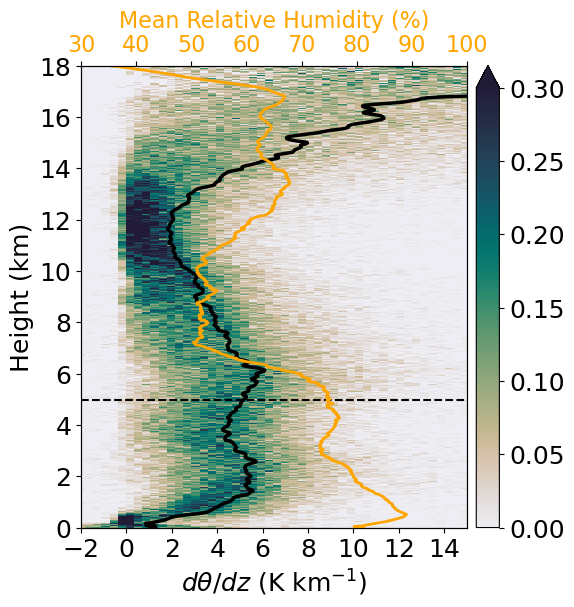

In [6]:
# Bin settings
# nbin=40
# fmin=-2
# fmax=10#15
# step=(fmax-fmin)/nbin
# bins=np.arange(fmin,fmax,step)+step
nbin=50
fmin=-2
fmax=16
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)

cfad_invar = dthdz*1e3 # K/km

# var_cfad = compute_cfad(cfad_invar, bins)
cfad_density, bin_edges = compute_cfad(cfad_invar, bins)
var_mean = np.nanmean(cfad_invar, axis=0)

rh_asc = calc_relh(snd_asc['mr'], snd_asc['p'], snd_asc['tmpk'], ice=True)
mean_rh = np.nanmean(rh_asc, axis=0)

mean_freezinglevel = np.nanmean(snd_asc['hght_0c'])

# Plot CFAD

fig,ax = plt.subplots(figsize=(6,6))

cfad = ax.pcolormesh(bins[:-1],hght/1000,cfad_density.transpose(),cmap=cmocean.cm.rain,norm=colors.Normalize(vmin=0,vmax=0.3),shading='nearest')
ax.plot(var_mean, hght/1000, color='black', linewidth=2.5, label='Mean')

#plot a horizontal line at the freezing level
ax.axhline(mean_freezinglevel/1000, color='black', linestyle='--', label='Mean freezing level')


cbar=plt.colorbar(cfad,location='right',orientation='vertical', extend='max',pad=0.02)
cbar.ax.tick_params(labelsize=18)

ax.set_xlim(-2,15)
ax.set_ylim(0,18)
#ax.set_title(r'$d\theta/dz$',fontsize=18)
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel(r'$d\theta/dz$ (K km$^{-1}$)',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

twiny = ax.twiny()
twiny.plot(mean_rh, hght/1000, '-', color='orange', linewidth=2)
twiny.set_xlabel('Mean Relative Humidity (%)', fontsize=16, color='orange')
twiny.set_xlim(30, 100)
twiny.set_xticklabels(twiny.get_xticklabels(), fontsize=16, color='orange')

plt.savefig('../../figures/Fig_cfad_lapserate.png')

In [7]:
mean_freezinglevel

np.float64(4986.645768025079)